# Playtester

Playtester notebook for the FINCH Predictive Coder Neural Network

# Setup

After running the setup cells, restart the runtime. Colab needs to refresh the updated libraries.

(this should take a minute)

In [1]:
%%time
%%capture

# install fpcnn package
!pip install git+https://github.com/DM1122/fpcnn

# download datasets
!wget https://raw.githubusercontent.com/DM1122/fpcnn/main/data/indian_pines.mat

CPU times: user 375 ms, sys: 77.4 ms, total: 453 ms
Wall time: 55.9 s


# Parameters

In [1]:
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Seed for all libraries
seed = 69 #@param {type:"integer"}

#@markdown Side length of cube to process from full dataset
size = 16 #@param {type:"slider", min:0, max:64, step:1}

#@markdown Goulomb rice code length
grc_m = 11 #@param {type:"slider", min:0, max:32, step:1}

#@markdown Draw plots in dark mode? (should always be checked)
dark_mode = True #@param {type:"boolean"}

#@markdown Double click to modify context selection
context_spatial_offsets = [
    [-1, 0, 0],
    [-1, -1, 0],
    [0, -1, 0],
    [1, -1, 0],
    [-1, 0, -1],
    [-1, -1, -1],
    [0, -1, -1],
    [1, -1, -1],
    [-1, 0, -2],
    [-1, -1, -2],
    [0, -1, -2],
    [1, -1, -2],
]

context_spectral_offsets = [[0, 0, -1], [0, 0, -2], [0, 0, -3], [0, 0, -4]]

# Config

In [2]:
import os
import random
import pandas as pd
import tensorflow as tf
import numpy as np
from fpcnn import core, pipe
from fpcnn.libs import benchmarklib, datalib, plotlib, printlib

# plant the seed
seed = 69
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# tensorflow config
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load

Load the sample dataset datacube.

In [3]:
# import data
data_original = datalib.load_data_hdf5(path="indian_pines.mat", header="indian_pines")

# crop data
data_original = data_original[0:size,0:size,0:size]
data_shape = (size,size,size)

Dataset .mat file version < 7.3. Importing with scipy...


Ndarray Stats: Original Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	2560,5598 (3038)
Mean:	4470.45
Median:	4567.0
σ:	636.3
σ²:	404883.57



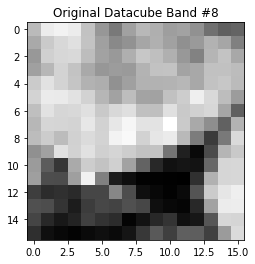

In [11]:
#@title Datacube { run: "auto", vertical-output: true }
band = 8 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_original, title="Original Datacube")
plotlib.plot_band(data=data_original, band=band, title=f"Original Datacube Band #{band}")


# Compression

Compress the original datacube using the FPCNN network. The compressed datacube spit out by FPCNN is an array of residuals between the original datacube voxels and the voxels predicted by the network.

In [12]:
# instantiate compressor network
compressor = core.FPCNN(
    offsets_spatial=context_spatial_offsets,
    offsets_spectral=context_spectral_offsets,
)

# save initial weights to be sent to decompressor
weights = compressor.get_weights()

In [13]:
#@title Info { vertical-output: true, display-mode: "form" }

print("Compressor model architecture:")
compressor.print_model()

print("Initial compressor weights and biases:")
print(weights)

Compressor model architecture:
Model: "FPCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Spatial_Context (InputLayer)    [(None, 12)]         0                                            
__________________________________________________________________________________________________
Spectral_Context (InputLayer)   [(None, 4)]          0                                            
__________________________________________________________________________________________________
Spatial_Extraction (Dense)      (None, 5)            65          Spatial_Context[0][0]            
__________________________________________________________________________________________________
Spectral_Extraction (Dense)     (None, 5)            25          Spectral_Context[0][0]           
_______________________________________________________________

In [14]:
%%time

# encode original datacube
data_residuals, losses = compressor.encode(data=data_original)

CPU times: user 25.2 s, sys: 77.3 ms, total: 25.2 s
Wall time: 25.5 s


In [15]:
#@title Info { vertical-output: true, display-mode: "form" }

# plot loss
df = pd.DataFrame(data=losses.flatten(), index=None, columns=["losses"], dtype=None, copy=False)
plotlib.plot_series(
    df=df,
    title="Prediction Coding Loss",
    traces=["losses"],
    indicies=None,
    x_errors=None,
    y_errors=None,
    title_x="Epoch",
    title_y="Loss",
    size=None,
    draw_mode="lines+markers",
    vlines=None,
    hlines=None,
    dark_mode=dark_mode,
)

# plot distributions
stack = np.stack((data_original.flatten(), data_residuals.flatten()), axis=1, out=None)
df = pd.DataFrame(
    data=stack, index=None, columns=["original", "residuals"], dtype=None, copy=False
)
plotlib.plot_dist(
    df=df,
    title="Original Datacube vs Residuals Distribution",
    traces=["original","residuals"],
    nbins=None,
    x_errors=None,
    y_errors=None,
    title_x="Value",
    title_y="Count",
    size=None,
    vlines=None,
    hlines=None,
    dark_mode=dark_mode,
)

Ndarray Stats: Residuals Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	int16
Bytes:	8192 (0.01MB)
Range:	-4230,3229 (7459)
Mean:	46.17
Median:	8.0
σ:	454.37
σ²:	206455.59



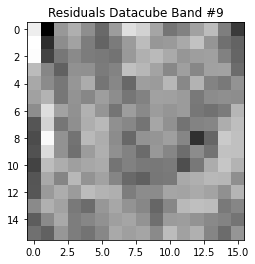

In [25]:
#@title Datacube { run: "auto", vertical-output: true, display-mode: "form" }
band = 9 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_residuals, title="Residuals Datacube")
plotlib.plot_band(data=data_residuals, band=band, title=f"Residuals Datacube Band #{band}")

# Mapping

Flatten the residuals datacube into a one-dimensional array and map the positive and negative values to solely positive values using an overlap and interleave scheme.

In [26]:
%%time
data_flattened = data_residuals.flatten()
data_mapped = pipe.map_residuals(data=data_flattened)

CPU times: user 6.13 ms, sys: 3 µs, total: 6.13 ms
Wall time: 6.6 ms


In [27]:
#@title Info { vertical-output: true, display-mode: "form" }

# plot distributions
stack = np.stack((data_residuals.flatten(), data_mapped.flatten()), axis=1, out=None)
df = pd.DataFrame(
    data=stack, index=None, columns=["residuals", "mapped"], dtype=None, copy=False
)
plotlib.plot_dist(
    df=df,
    title="Residuals vs Mapped Distribution",
    traces=["residuals","mapped"],
    nbins=None,
    x_errors=None,
    y_errors=None,
    title_x="Value",
    title_y="Count",
    size=None,
    vlines=None,
    hlines=None,
    dark_mode=dark_mode,
)

printlib.print_ndarray_stats(array=data_mapped, title="Mapped")

Ndarray Stats: Mapped
Shape:	(4096,)
Size:	4096
Dims:	1
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	0,8459 (8459)
Mean:	489.1
Median:	250.0
σ:	771.19
σ²:	594728.43
[6344 2459 4856 3865 4492]...[ 55 100 150  89 121]



# Encoding

Encode the mapped array to binary using Goloumb-Rice coding. After this step the data is ready to be transmitted.

In [28]:
%%time
data_encoded = pipe.grc_encode(data=data_mapped, m=grc_m)

CPU times: user 55.4 ms, sys: 66 µs, total: 55.5 ms
Wall time: 61.3 ms


In [29]:
#@title Info { vertical-output: true, display-mode: "form" }

printlib.print_ndarray_stats(array=data_encoded, title="Encoding")

Ndarray Stats: Encoding
Shape:	(49378,)
Size:	49378
Dims:	1
Type:	uint8
Bytes:	49378 (0.05MB)
Range:	0,1 (1)
Mean:	0.37
Median:	0.0
σ:	0.48
σ²:	0.23
[1 1 1 0 0]...[1 1 0 0 1]



# Decoding

Decode the received bitstream using the inverse Goulomb-Rice coding.

In [30]:
%%time
data_decoded = pipe.grc_decode(code=data_encoded, m=grc_m)

CPU times: user 81.2 ms, sys: 16 µs, total: 81.2 ms
Wall time: 86.1 ms


In [31]:
#@title Info { vertical-output: true, display-mode: "form" }

printlib.print_ndarray_stats(array=data_decoded, title="Decoding")

acc = benchmarklib.get_acc(A=data_mapped, B=data_decoded)
print(f"Decoding accuracy:\t{acc*100}%")




Ndarray Stats: Decoding
Shape:	(4096,)
Size:	4096
Dims:	1
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	0,8459 (8459)
Mean:	489.1
Median:	250.0
σ:	771.19
σ²:	594728.43
[6344 2459 4856 3865 4492]...[ 55 100 150  89 121]

Decoding accuracy:	100.0%


# Remapping

Remap the decoded bitstream of positive intergers back to their original positive and negative values using the inverse of the overlap and interleave scheme. Also reshape the one-dimensional array back to a three-dimensional array.

In [32]:
%%time
data_remapped = pipe.remap_residuals(data=data_decoded)
data_reshaped = data_remapped.reshape(data_shape)

CPU times: user 5.43 ms, sys: 0 ns, total: 5.43 ms
Wall time: 7.37 ms


In [33]:
#@title Info { vertical-output: true, display-mode: "form" }

acc = benchmarklib.get_acc(A=data_residuals.flatten(), B=data_reshaped.flatten())
print(f"Remapping accuracy:\t{acc*100}%")

Remapping accuracy:	100.0%


Ndarray Stats: Recovered Residuals Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	int16
Bytes:	8192 (0.01MB)
Range:	-4230,3229 (7459)
Mean:	46.17
Median:	8.0
σ:	454.37
σ²:	206455.98



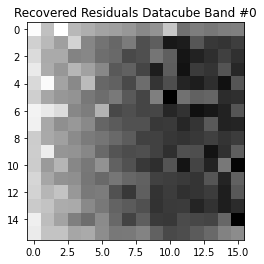

In [ ]:
#@title Datacube { run: "auto", vertical-output: true, display-mode: "form" }
band = 0 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_reshaped, title="Recovered Residuals Datacube")
plotlib.plot_band(data=data_reshaped, band=band, title=f"Recovered Residuals Datacube Band #{band}")

# Decompression

Decompress the residuals datacube by running the decompression variant of the FPCNN algorithm. The output of the decompressor is the original datacube.

In [34]:
%%time
decompressor = core.FPCNN(
    offsets_spatial=context_spatial_offsets,
    offsets_spectral=context_spectral_offsets,
)
decompressor.set_weights(weights=weights)
data_recovered, losses_decompression = decompressor.decode(data=data_reshaped)


CPU times: user 29 s, sys: 197 ms, total: 29.2 s
Wall time: 29.8 s


In [ ]:
#@title Info { vertical-output: true, display-mode: "form" }
acc = benchmarklib.get_acc(A=data_original.flatten(), B=data_recovered.flatten())
print(f"Decompression accuracy:\t{acc*100}%")

Decompression accuracy:	100.0%


Ndarray Stats: Recovered Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	2560,5598 (3038)
Mean:	4470.45
Median:	4567.0
σ:	636.3
σ²:	404883.57



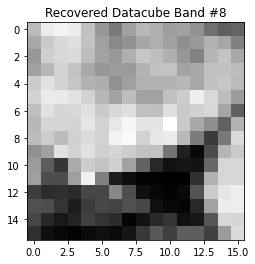

In [ ]:
#@title Datacube { run: "auto", vertical-output: true }
band = 8 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_recovered, title="Recovered Datacube")
plotlib.plot_band(data=data_recovered, band=band, title=f"Recovered Datacube Band #{band}")

# Benchmarking

In [ ]:
# WIP (calculation of compression factor, etc)